In [11]:
import os

import matplotlib.pyplot as plt
from monai.data import ImageDataset
from monai.transforms import Resize, EnsureChannelFirst, Compose
from torch.utils.data import DataLoader

from evaluate_util import get_model

In [12]:

transformer = Compose([EnsureChannelFirst(),
                       Resize((160, 160))])

exp_path = "experiments/" + "2024_03_06__10_42_58" + "/"
val_image_path = "data/REFUGE2/Validation/Images/"
val_dm_path = "data/REFUGE2/Validation/Disc_Masks/"

val_data = ImageDataset(image_files=[val_image_path + file for file in os.listdir(val_image_path)],
                          transform=transformer,
                          seg_files=[val_dm_path + file for file in os.listdir(val_dm_path)],
                          seg_transform=transformer)

train_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

In [13]:
def plot_sample(sample):
    fig, (img1, img2) = plt.subplots(1, 2, layout="constrained")

    img1.imshow(sample[0].permute(1, 2, 0) / 255)
    img1.set_axis_off()
    img2.imshow(sample[1].permute(1, 2, 0) / 255, cmap="gray")
    img2.set_axis_off()
    plt.show()

In [14]:
model, _ = get_model(exp_path)

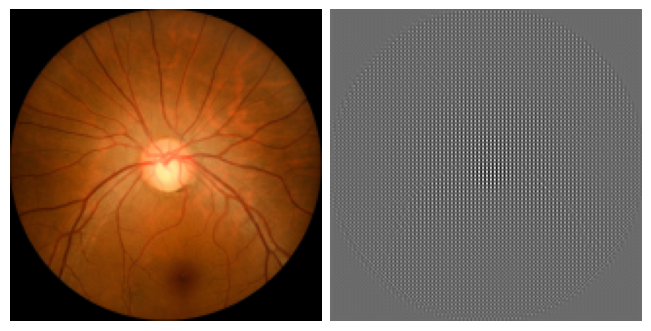

In [15]:
for batch in train_dataloader:
    new_images = model(batch[0])
    plot_sample((batch[0][20], new_images[20].detach()))
    break